### Imports

In [2]:
import os
import keras
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from PIL import Image
from sklearn.model_selection import train_test_split

### Config

In [3]:
SEED       = 68857869
BATCH_SIZE = 32
IMG_WIDTH  = 128
IMG_HEIGHT = 128
BETA       = 0.9

tf.keras.utils.set_random_seed(SEED)

### Dataset Download and Preparation

In [ ]:
%%capture
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
!unzip DIV2K_train_LR_x8.zip
!ls DIV2K_train_LR_x8/ | wc -l

### Data Loading and Preprocessing

In [5]:
def decode_img(img):
  img = tf.io.read_file(img)
  img = tf.io.decode_image(img, channels=3)
  return img

def augment_img(img,img_width,img_height):
  img = tf.image.random_crop(value=img, size=(img_width, img_height,3),seed=SEED)
  img = tf.image.random_flip_left_right(img,seed=SEED)
  img = tf.image.random_flip_up_down(img,seed=SEED)
  return tf.cast(img, tf.float32)/255.0

def datapipe(files,batch_size,img_width,img_height,name):
  cover = tf.data.Dataset.from_tensor_slices(files)
  cover = cover.map(lambda x: decode_img(x))
  cover = cover.map(lambda x: augment_img(x,img_width,img_height)).repeat(10)

  random.shuffle(files)

  payload = tf.data.Dataset.from_tensor_slices(files)
  payload = payload.map(lambda x: decode_img(x))
  payload = payload.map(lambda x: augment_img(x,img_width,img_height)).repeat(10)

  data = tf.data.Dataset.zip(cover,payload)
  ds = tf.data.Dataset.zip(data,data)

  ds = ds.shuffle(buffer_size=100)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

file_list    = [f"DIV2K_train_LR_x8/{_file}" for _file in os.listdir('DIV2K_train_LR_x8')]
select_files = []
for _file in file_list:
  img = Image.open(_file)
  if img.size[0] >= IMG_WIDTH and img.size[1] >= IMG_HEIGHT:
    select_files.append(_file)

train , val = train_test_split(select_files,train_size=0.7)

train_dataset = datapipe(train,BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,'train')
val_dataset   = datapipe(val,BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,'val')

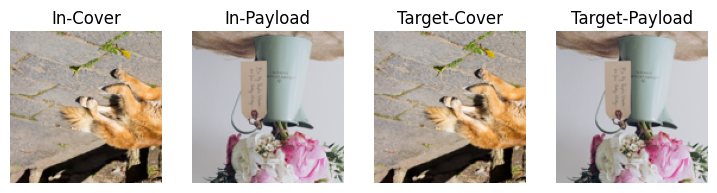

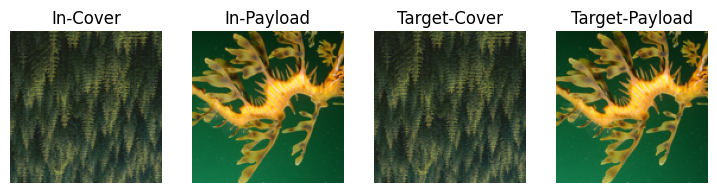

In [6]:
for target,predict in train_dataset.take(2):
    cover = target[0][0].numpy()
    payload = target[1][0].numpy()

    #print(cover.dtype,cover.max(),cover.min())

    fig, ax = plt.subplots(1, 4, figsize=(9, 5))

    ax[0].imshow(cover)
    ax[0].set_title('In-Cover')
    ax[0].axis('off')

    ax[1].imshow(payload)
    ax[1].set_title('In-Payload')
    ax[1].axis('off')

    cover = predict[0][0].numpy()
    payload = predict[1][0].numpy()

    ax[2].imshow(cover)
    ax[2].set_title('Target-Cover')
    ax[2].axis('off')

    ax[3].imshow(payload)
    ax[3].set_title('Target-Payload')
    ax[3].axis('off')

    plt.show()

### Model Definition

In [8]:
def conv_layer(x, num_filters, activation='relu', name='conv_layer'):
    x = keras.layers.Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv')(x)
    x = keras.layers.BatchNormalization(name=f'{name}_bn')(x)
    x = keras.layers.Activation(activation, name=f'{name}_act')(x)
    return x

def encoder():
    cover_input = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='cover_input')
    payload_input = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='payload_input')

    conc_layer = keras.layers.Concatenate(name='concat_cover_payload')([cover_input, payload_input])

    l1 = conv_layer(conc_layer, 64, name='encoder_l1')
    l2 = conv_layer(l1, 128, name='encoder_l2')
    l3 = conv_layer(l2, 256, name='encoder_l3')
    l4 = conv_layer(l3, 512, name='encoder_l4')
    l5 = conv_layer(l4, 512, name='encoder_l5')

    x = keras.layers.Concatenate(name='concat_l3_l5')([l3, l5])
    l6 = conv_layer(x, 256, name='encoder_l6')

    x = keras.layers.Concatenate(name='concat_l2_l6')([l2, l6])
    l7 = conv_layer(x, 128, name='encoder_l7')

    x = keras.layers.Concatenate(name='concat_l1_l7')([l1, l7])
    l8 = conv_layer(x, 64, name='encoder_l8')

    steg_image = conv_layer(l8, 3, activation='sigmoid', name='encoder_output')

    encoder_model = keras.Model(inputs=[cover_input, payload_input], outputs=steg_image, name='encoder')
    return encoder_model

def decoder():
    steg_input = keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='steg_image_input')
    x = conv_layer(steg_input, 64, name='decoder_l1')
    x = conv_layer(x, 128, name='decoder_l2')
    x = conv_layer(x, 256, name='decoder_l3')
    x = conv_layer(x, 128, name='decoder_l4')
    x = conv_layer(x, 64, name='decoder_l5')
    x = conv_layer(x, 3, activation='sigmoid', name='decoder_output')

    decoder_model = keras.Model(inputs=steg_input, outputs=x, name='decoder')
    return decoder_model

In [9]:
cover_input = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='cover_input')
payload_input = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='payload_input')

encoder_model = encoder()
decoder_model = decoder()

steg_image    = encoder_model([cover_input, payload_input])
payload_image = decoder_model(steg_image)

model = keras.Model(inputs=[cover_input, payload_input], outputs=[steg_image,payload_image], name='steg_model')
model.summary()

Model: "steg_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cover_input (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 payload_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 encoder (Functional)        (None, 128, 128, 3)          6244815   ['cover_input[0][0]',         
                                                                     'payload_input[0][0]']       
                                                                                                  
 decoder (Functional)        (None, 128, 128, 3)          743951    ['encoder[0][0]']    

### Metric functions

In [10]:
def psnr(true,pred):
    return tf.image.psnr(true,pred,1.)

def ssim(true,pred):
    return tf.image.ssim(true,pred,1.)

### Training


In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    loss_weights=[1,BETA],
    metrics=[
      [psnr,ssim],
      [psnr,ssim]
])

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

### Testing

In [ ]:
!wget https://picsum.photos/128.jpg -O payload.jpg

In [ ]:
!wget https://picsum.photos/128.jpg -O cover.jpg

In [20]:
PAYLOAD_IMG_PATH  = "payload.jpg"
COVER_IMG_PATH    = "cover.jpg"

In [21]:
cover   = decode_img(COVER_IMG_PATH)
payload = decode_img(PAYLOAD_IMG_PATH)

cover   = tf.expand_dims(cover, axis=0)/255
payload = tf.expand_dims(payload, axis=0)/255

In [28]:
steg_image = encoder_model([cover,payload])
decoded_image = decoder_model(steg_image)

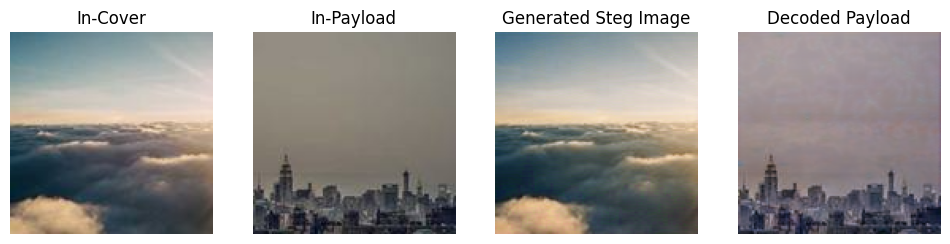

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(12, 7))

ax[0].imshow(cover[0])
ax[0].set_title('In-Cover')
ax[0].axis('off')

ax[1].imshow(payload[0])
ax[1].set_title('In-Payload')
ax[1].axis('off')

ax[2].imshow(steg_image[0])
ax[2].set_title('Generated Steg Image')
ax[2].axis('off')

ax[3].imshow(decoded_image[0])
ax[3].set_title('Decoded Payload')
ax[3].axis('off')

plt.show()